In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# COL_NAMES = ["t", "is_crashed",
#              "roll", "pitch", "yaw", "throttle",
#              "roll_pid_out", "pitch_pid_out", "yaw_pid_out",
#              "motor_fl", "motor_bl", "motor_fr", "motor_br", 
#              "pwm_fl", "pwm_bl", "pwm_fr", "pwm_br"]
# COL_DATATYPES = {0: int, 1: bool,
#              2: float, 3: float, 4: float, 5: float,
#              6: float, 7: float, 8: float,
#              9: float, 10: float, 11: float, 12: float, 
#              13: int, 14: int, 15: int, 16: int}

def load_csv(file):
    # File locations
    log_path = "../logs/" + file

    csv_df = pd.read_csv(log_path)
    csv_df.columns = csv_df.columns.str.replace(" ","")

    return csv_df

In [29]:
# Load flight logs
flight_df = load_csv("pcb_logging_test.csv")
flight_df.head()

,t,is_crashed,roll,pitch,yaw,throttle,roll_pid_out,pitch_pid_out,yaw_pid_out,motor_fl,motor_bl,motor_fr,motor_br,pwm_fl,pwm_bl,pwm_fr,pwm_br
0,6169,0,0.0,-0.0,0.0,-1.0,-0.00,0.00,0.0,0.0,0.0,0.0,0.0,819,819,819,819
1,6177,0,0.0,-0.0,0.0,-1.0,-0.03,0.04,0.0,0.0,0.0,0.0,0.0,819,819,819,819
2,6182,0,0.0,-0.0,0.0,-1.0,-0.04,0.06,0.0,0.0,0.0,0.0,0.0,819,819,819,819
3,6188,0,0.0,-0.0,0.0,-1.0,-0.04,0.05,0.0,0.0,0.0,0.0,0.0,819,819,819,819
4,6193,0,0.0,-0.0,0.0,-1.0,-0.04,0.07,0.0,0.0,0.0,0.0,0.0,819,819,819,819


In [31]:
# Time - DF -> Numpy
t_df = flight_df['t']
t_np = t_df.to_numpy(dtype=np.int16)
t_np = t_np / 1000

# Roll / Pitch / Yaw - DF -> Numpy
rpy_df = flight_df[['roll', 'pitch', 'yaw']]
rpy_np = rpy_df.to_numpy()

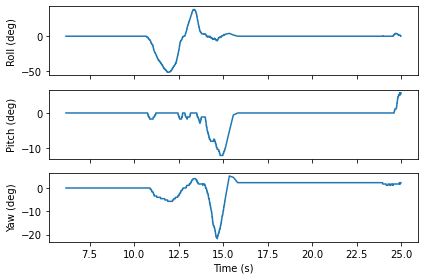

In [34]:
# Plotting indices
idx_start = 0
idx_end = np.size(t_np)

# Clip variables
t_clip = t_np[idx_start:idx_end]
roll = rpy_np[idx_start:idx_end, 0]
pitch = rpy_np[idx_start:idx_end, 1]
yaw = rpy_np[idx_start:idx_end, 2]

# Convert RPY to degrees
roll = np.degrees(roll)
pitch = np.degrees(pitch)
yaw = np.degrees(yaw)


# Plotting RPY
f, axs = plt.subplots(3, sharex=True)

axs[0].plot(t_clip, roll)
axs[0].set_ylabel("Roll (deg)")

axs[1].plot(t_clip, pitch)
axs[1].set_ylabel("Pitch (deg)")

axs[2].plot(t_clip, yaw)
axs[2].set_ylabel("Yaw (deg)")
axs[2].set_xlabel("Time (s)")

f.tight_layout()

plt.show()

